# Higgs Challenge Example using Neural Networks
In this part we will look at the **[Higgs Boson ML Challenge](https://www.kaggle.com/c/Higgs-boson)** on Kaggle and attempt a solution using neural networks (NN). The data is available from **[CERN Open Data](http://opendata.cern.ch/record/328)**. More information about the data is available from the links, and in particular at **[Documentation](http://opendata.cern.ch/record/329/files/atlas-higgs-challenge-2014.pdf)**. The general idea is that we want to extract $H\to\tau\tau$ signal from background. In particular, the selection requires one of the taus to decay into an electron or muon and two neutrinos, and the other into hadrons and a neutrino. The challenge is based on Monte Carlo events processed through the **[ATLAS detector](http://atlas.cern/)** simulation and reconstruction.


## Background on Neural Networks
(based on lectures from **[ML Course on Coursera](https://www.coursera.org/learn/machine-learning)**)

As we saw from the logistic regression yesterday, linear classifiers are often not the best at solving complicated problems. Neural networks introduce nonlinearity. They were originally designed to mimic the brain, and were popular in the 80s and early 90s. Recently they have become popular again, especially as deep neural networks DNNs, including convolutional NNs (CNN), recurrent NNs (RNN), etc. Those are beyond the scope of this class, but we will introduce the basics of NNs.

Below is a diagram of a simple NN:
![NNFig](https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg)
It is made up of "neurons" that get a number of inputs, processes them, and sends the output to other neurons. 
* Mathematically, one can represent the a neuron's "activation" $a = g\left(\theta^Tx\right)$, where $x$ are the inputs (a vector), and $\theta$ are the parameters (weights) of the model (also a vector), and $g$ is the activation fuction. 
* For example, if we use a logistic function as the activation function, we can have $g\left(\theta^Tx\right) = \frac{1}{1+\mathrm{exp}\left(-\theta^Tx\right)}$, 
* or if a Rectified Linear Unit (ReLU), $g\left(\theta^Tx\right) = \mathrm{max}\left(0, \theta^Tx\right)$. 
* The NN above has an input layer (layer 1), a hidden layer (layer 2), and an output layer (layer 3). One can have more hidden layers. 

* Let's label the activations of layer 2 as $a_i^{(2)} = g\left(\theta_i^{(1)T}x\right)$, where $i$ is the index of the individual neurons. 
* Note that the superscript of the $\theta$ is (1). That is because these are the weights going from layer 1 to 2. Putting together all the individual weight vectors together forms a matrix $\Theta^{(1)}$.

Using matrix notation, we can define $z^{(j)} = \Theta^{(j-1)}a^{(j-1)}$ and then $a^{(j)} = g(z^{(j)})$. Thus evaluating the NN is a series of matrix multiplications followed by activation functions.


The cost function of a NN is similar to what we have for logistic regression, modified to take into account possible multiple outputs, and with more complicated regularization. In order to train the NN, we have to determine the weight matrix $\Theta$ that minimizes the cost function. Backpropagation is the method used to do that. It calculates the partial derivatives "errors" for each $z_i^{(j)}$ by propagating the errors backwards. Usually something like (stochastic) gradient descent is used to solve the problem. For more details on backprorpagation, look, for example, at the **[ML course](https://www.coursera.org/learn/machine-learning)** mentioned above.

Now let's start trying to apply a NN to the Higgs Challenge data. We will start using Scikit Learn, and then try **[Keras](https://keras.io/)**.

In [1]:
# the usual setup: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load training data
df = pd.read_csv('data/atlas-higgs-challenge-2014-v2.csv.gz')

In [3]:
df.iloc[:5]

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


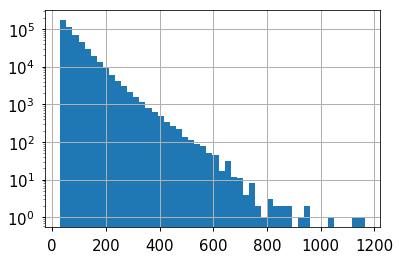

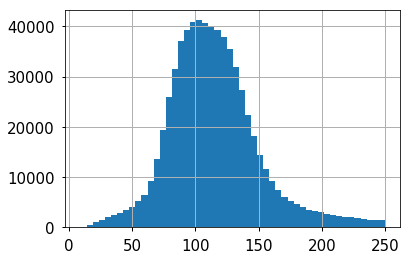

In [4]:
df.PRI_jet_leading_pt[df.PRI_jet_leading_pt>0].hist(bins=50)
plt.yscale('log')

f=plt.figure()
df.DER_mass_MMC[(df.DER_mass_MMC>0)&(df.DER_mass_MMC<250)].hist(bins=50)

There is more information about the variables in the documentation. The variables that start with **DER** are derived quantities, determined by the physicists performing the analysis as variables that discriminate signal from backround. On the other hand, those that start with **PRI** are considered to be primary variables, from which the derived variables are calculated. They themselves generally do not provide much discrimination, but one if the ideas suggested by deep networks is that they can determine the necessary features from the primary variables, potentially even finding variables that the physicists did not consider. *EventId* identifies the event but is not a "feature." The *Weight* is the event weight so that the sum of weights of all signal events should produce the signal yield expected to be observed in 2012, and the sum of weights of all background events should produce the backgroudn yield. Note that the weight varies event to event, because different background and signal processes contribute to the background and signal sets. *Label* indicates if it is a signal or background event. Ignore the *Kaggle* variables--they are only used if you want to reproduce exactly what was used in the Challenge. 

In [5]:
# map y values to integers
df['Label'] = df['Label'].map({'b':0, 's':1})
df

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.240,-2.475,113.497,0.000814,1,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.000,-999.000,46.226,0.681042,0,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,0,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,0,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,0,t,6.245333
5,100005,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,...,-2.412,-0.653,56.165,0.224,3.106,193.660,0.025434,0,t,0.083414
6,100006,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,...,0.864,1.450,56.867,0.131,-2.767,179.877,0.000814,1,t,0.002653
7,100007,154.916,10.418,94.714,29.169,-999.000,-999.000,-999.000,2.897,1.526,...,-0.715,-1.724,-999.000,-999.000,-999.000,30.638,0.005721,1,t,0.018636
8,100008,105.594,50.559,100.989,4.288,-999.000,-999.000,-999.000,2.904,4.288,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.614803,0,t,5.296003
9,100009,128.053,88.941,69.272,193.392,-999.000,-999.000,-999.000,1.609,28.859,...,-2.767,-2.514,-999.000,-999.000,-999.000,167.735,0.000461,1,t,0.001502


In [ ]:
df.iloc[:5]

In [6]:
# let's create separate arrays
eventID = df['EventId']
X = df.loc[:,'DER_mass_MMC':'PRI_jet_all_pt']
y = df['Label']
weight = df['Weight']

In [7]:
#now split into testing and training samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, eventID_train, event_ID_test, weight_train, weight_test = train_test_split(
    X, y, eventID, weight, test_size=0.33, random_state=42)

In [8]:
# now let's first look at a NN in sklearn
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(verbose=True)


In [9]:
# and train
mlp.fit(X_train, y_train)

Iteration 1, loss = 1.09661620
Iteration 2, loss = 0.77360641
Iteration 3, loss = 0.69369140
Iteration 4, loss = 0.65115646
Iteration 5, loss = 0.65273863
Iteration 6, loss = 0.59829970
Iteration 7, loss = 0.58051744
Iteration 8, loss = 0.55886981
Iteration 9, loss = 0.54314695
Iteration 10, loss = 0.52709540
Iteration 11, loss = 0.51315467
Iteration 12, loss = 0.50276055
Iteration 13, loss = 0.49673716
Iteration 14, loss = 0.48118571
Iteration 15, loss = 0.47269283
Iteration 16, loss = 0.46676295
Iteration 17, loss = 0.45607049
Iteration 18, loss = 0.44819029
Iteration 19, loss = 0.44177381
Iteration 20, loss = 0.43835115
Iteration 21, loss = 0.43470856
Iteration 22, loss = 0.42708861
Iteration 23, loss = 0.42272210
Iteration 24, loss = 0.41844147
Iteration 25, loss = 0.41583758
Iteration 26, loss = 0.41298021
Iteration 27, loss = 0.41073323
Iteration 28, loss = 0.40745335
Iteration 29, loss = 0.40654803
Iteration 30, loss = 0.40497223
Iteration 31, loss = 0.40339184
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [10]:
mlp.score(X_test, y_test)

0.820245982690107

The Kaggle competition used the approximate median segnificance (AMS), as defined below, to determine how good a solution was. The number 10, added to the background yield, is a regularization term to decrease the variance of the AMS.

Note that if you do not use the full data set (i.e. you split into training and testing) you have to reweigh the inputs so that the subsample yield matches to the toal yield, which we will do below.

In [11]:
# compute approximate median segnificance (AMS)

def ams(s,b):
    from math import sqrt,log
    if b==0:
        return 0

    return sqrt(2*((s+b+10)*log(1+float(s)/(b+10))-s))


In [12]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob = mlp.predict_proba(X_train)[:, 1]
y_test_prob = mlp.predict_proba(X_test)[:, 1]
pcut = np.percentile(y_train_prob,85)
pcut

0.7374296857662506

In [13]:
# add the probability to the original data frame
df['Prob']=mlp.predict_proba(X)[:, 1]


/home/gduckeck/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/gduckeck/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


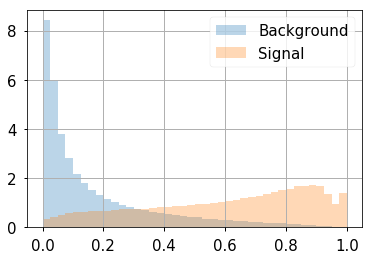

In [14]:
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

df[df.Label==0].Prob.hist(label='Background',**kwargs)
df[df.Label==1].Prob.hist(label='Signal',**kwargs)
plt.legend()


In [15]:
# Let's calculate the total weights (yields)
sigall = weight.dot(y)
backall = weight.dot(y == 0)

# The training weights
sigtrain = weight_train.dot(y_train)
backtrain = weight_train.dot(y_train == 0)

# The training weights
sigtest = weight_test.dot(y_test)
backtest = weight_test.dot(y_test == 0)

# aside:  these can also be done by looping instead of using a dot product
#  (Usually vectorized operations are faster for interpreted code)

In [16]:
# Now let's look at event yields that pass our selection
sigtrain_sel = weight_train.dot(np.multiply(y_train, y_train_prob > pcut))
backtrain_sel = weight_train.dot(np.multiply(y_train == 0, y_train_prob > pcut))

sigtest_sel = weight_test.dot(np.multiply(y_test, y_test_prob > pcut))
backtest_sel = weight_test.dot(np.multiply(y_test == 0, y_test_prob > pcut))


In [17]:
# Now we need to correct the selected yields to be is if we used the full sample
sigtrain_sel_corr = sigtrain_sel*sigall/sigtrain
backtrain_sel_corr = backtrain_sel*backall/backtrain

sigtest_sel_corr = sigtest_sel*sigall/sigtest
backtest_sel_corr = backtest_sel*backall/backtest

print("Corrected selected yields in training sample, signal =", sigtrain_sel_corr, ", background =",backtrain_sel_corr)
print("Corrected selected yields in test sample, signal =", sigtest_sel_corr, ", background =",backtest_sel_corr)


Corrected selected yields in training sample, signal = 263.8957425160544 , background = 7523.137450569208
Corrected selected yields in test sample, signal = 263.23220559287773 , background = 7605.314126341242


In [17]:
print("AMS of training sample", ams(sigtrain_sel_corr,backtrain_sel_corr))
print("AMS of test sample", ams(sigtest_sel_corr,backtest_sel_corr))

AMS of training sample 3.1082926036692693
AMS of test sample 3.034135675570529


How did we do? Worse than the BDT from yesterday.
![Comparison with submissions](data/tr150908_davidRousseau_TMVAFuture_HiggsML.001.png)

Neural networks are quite sensitive to feature scaling, so let's try to scale the features.

In [18]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train.columns

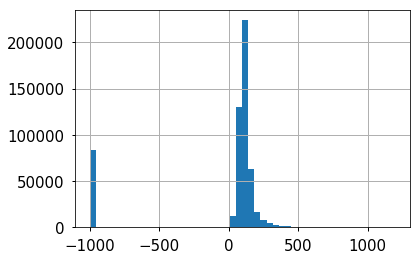

In [19]:
X_train.DER_mass_MMC.hist(bins=50)

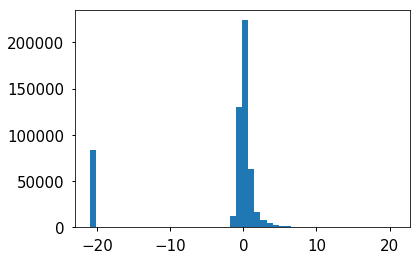

In [20]:
a=plt.hist(X_train_scaled[:,0],bins=50)

In [21]:
# and train a new network
mlp_scaled = MLPClassifier(verbose=True)
mlp_scaled.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.40567153
Iteration 2, loss = 0.37743384
Iteration 3, loss = 0.37171010
Iteration 4, loss = 0.36869241
Iteration 5, loss = 0.36671551
Iteration 6, loss = 0.36552037
Iteration 7, loss = 0.36464791
Iteration 8, loss = 0.36379843
Iteration 9, loss = 0.36321345
Iteration 10, loss = 0.36255538
Iteration 11, loss = 0.36224304
Iteration 12, loss = 0.36185050
Iteration 13, loss = 0.36155966
Iteration 14, loss = 0.36112230
Iteration 15, loss = 0.36105074
Iteration 16, loss = 0.36069082
Iteration 17, loss = 0.36051894
Iteration 18, loss = 0.36017131
Iteration 19, loss = 0.36015432
Iteration 20, loss = 0.35996604
Iteration 21, loss = 0.35989021
Iteration 22, loss = 0.35958988
Iteration 23, loss = 0.35958384
Iteration 24, loss = 0.35942606
Iteration 25, loss = 0.35913098
Iteration 26, loss = 0.35924665
Iteration 27, loss = 0.35907309
Iteration 28, loss = 0.35900896
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [22]:
mlp_scaled.score(X_test_scaled, y_test)

0.8371484969576215

In [23]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob_scaled = mlp_scaled.predict_proba(X_train_scaled)[:, 1]
y_test_prob_scaled = mlp_scaled.predict_proba(X_test_scaled)[:, 1]
pcut_scaled = np.percentile(y_train_prob_scaled,85)


In [24]:
# Now let's look at event yields that pass our selection
sigtrain_sel_scaled = weight_train.dot(np.multiply(y_train, y_train_prob_scaled > pcut_scaled))
backtrain_sel_scaled = weight_train.dot(np.multiply(y_train == 0, y_train_prob_scaled > pcut_scaled))

sigtest_sel_scaled = weight_test.dot(np.multiply(y_test, y_test_prob_scaled > pcut_scaled))
backtest_sel_scaled = weight_test.dot(np.multiply(y_test == 0, y_test_prob_scaled > pcut_scaled))


In [25]:
# Now we need to correct the selected yields to be is if we used the full sample
sigtrain_sel_scaled_corr = sigtrain_sel_scaled*sigall/sigtrain
backtrain_sel_scaled_corr = backtrain_sel_scaled*backall/backtrain

sigtest_sel_scaled_corr = sigtest_sel_scaled*sigall/sigtest
backtest_sel_scaled_corr = backtest_sel_scaled*backall/backtest

print("Corrected selected yields in training sample, signal =", sigtrain_sel_scaled_corr, ", background =",backtrain_sel_scaled_corr)
print("Corrected selected yields in test sample, signal =", sigtest_sel_scaled_corr, ", background =",backtest_sel_scaled_corr)


Corrected selected yields in training sample, signal = 230.2290305975397 , background = 4207.713837982401
Corrected selected yields in test sample, signal = 228.54406510620893 , background = 4519.307063997606


In [26]:
print("AMS of training sample", ams(sigtrain_sel_scaled_corr,backtrain_sel_scaled_corr))
print("AMS of test sample", ams(sigtest_sel_scaled_corr,backtest_sel_scaled_corr))

AMS of training sample 3.513503562990113
AMS of test sample 3.3679188562698963


We improved somewhat.

SciKit Learn has simple NNs, but if you want to do deep NNs, or train on GPUs, you probalby want to use something like Keras instead. Let's try to create a simple NN using Keras.

In [27]:
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential
from keras.layers import Dense


/home/gduckeck/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [49]:
# create the model
from keras import regularizers

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(30,), kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(1, activation='sigmoid'))


In [50]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
class_weight = {0: y_train.shape[0]/backtrain, 1:y_train.shape[0]/sigtrain}
class_weight

{0: 1.9909186536998906, 1: 1182.3150708555781}

In [51]:
#model.fit(X_train_scaled, y_train, epochs=5, batch_size=128, sample_weight=weight_train)
model.fit(X_train_scaled, y_train, epochs=5, batch_size=64)


Epoch 1/5
548219/548219 [==============================] - 14s 26us/step - loss: 0.4015 - acc: 0.8225
Epoch 2/5
548219/548219 [==============================] - 14s 25us/step - loss: 0.3824 - acc: 0.8317
Epoch 3/5
548219/548219 [==============================] - 14s 26us/step - loss: 0.3771 - acc: 0.8339
Epoch 4/5
548219/548219 [==============================] - 14s 26us/step - loss: 0.3749 - acc: 0.8345
Epoch 5/5
548219/548219 [==============================] - 14s 25us/step - loss: 0.3739 - acc: 0.8348


In [52]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob_keras = model.predict(X_train_scaled)[:, 0]
y_test_prob_keras = model.predict(X_test_scaled)[:, 0]
pcut_keras = np.percentile(y_train_prob_keras,85)


In [53]:
y_test_prob_keras

array([0.8595679 , 0.1556208 , 0.03185635, ..., 0.21461262, 0.08116557,
       0.02808595], dtype=float32)

In [54]:
# Now let's look at event yields that pass our selection
sigtrain_sel_keras = weight_train.dot(np.multiply(y_train, y_train_prob_keras > pcut_keras))
backtrain_sel_keras = weight_train.dot(np.multiply(y_train == 0, y_train_prob_keras > pcut_keras))

sigtest_sel_keras = weight_test.dot(np.multiply(y_test, y_test_prob_keras > pcut_keras))
backtest_sel_keras = weight_test.dot(np.multiply(y_test == 0, y_test_prob_keras > pcut_keras))


In [55]:
# Now we need to correct the selected yields to be is if we used the full sample
sigtrain_sel_keras_corr = sigtrain_sel_keras*sigall/sigtrain
backtrain_sel_keras_corr = backtrain_sel_keras*backall/backtrain

sigtest_sel_keras_corr = sigtest_sel_keras*sigall/sigtest
backtest_sel_keras_corr = backtest_sel_keras*backall/backtest

print("Corrected selected yields in training sample, signal =", sigtrain_sel_keras_corr, ", background =",backtrain_sel_keras_corr)
print("Corrected selected yields in test sample, signal =", sigtest_sel_keras_corr, ", background =",backtest_sel_keras_corr)


Corrected selected yields in training sample, signal = 235.8955925518231 , background = 4809.411277425625
Corrected selected yields in test sample, signal = 235.68968494766844 , background = 5045.200749907617


In [56]:
print("AMS of training sample", ams(sigtrain_sel_keras_corr,backtrain_sel_keras_corr))
print("AMS of test sample", ams(sigtest_sel_keras_corr,backtest_sel_keras_corr))

AMS of training sample 3.370825980185291
AMS of test sample 3.2896364370361337


We only made a single layer NN in Keras. However, you can easily change the structure of the network. As an assignment, try adding an extra hidden layer and changing the number of neurons.

There are a few things we can easily vary: number of hidden layers, the activation function, the regularization ($\alpha$). Let's go back to MLPClassifer (scaled) and play with some of them.

In [57]:
mlp_play = MLPClassifier(activation='relu', hidden_layer_sizes=(100,100), alpha=0.01, verbose=True)
mlp_play.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.38851825
Iteration 2, loss = 0.37135889
Iteration 3, loss = 0.36824245
Iteration 4, loss = 0.36636816
Iteration 5, loss = 0.36511768
Iteration 6, loss = 0.36414832
Iteration 7, loss = 0.36350149
Iteration 8, loss = 0.36293814
Iteration 9, loss = 0.36246490
Iteration 10, loss = 0.36216998
Iteration 11, loss = 0.36172783
Iteration 12, loss = 0.36141198
Iteration 13, loss = 0.36130314
Iteration 14, loss = 0.36122711
Iteration 15, loss = 0.36096829
Iteration 16, loss = 0.36066835
Iteration 17, loss = 0.36059962
Iteration 18, loss = 0.36042706
Iteration 19, loss = 0.36032510
Iteration 20, loss = 0.36017700
Iteration 21, loss = 0.36030321
Iteration 22, loss = 0.36008982
Iteration 23, loss = 0.35995420
Iteration 24, loss = 0.35994922
Iteration 25, loss = 0.35979653
Iteration 26, loss = 0.35983207
Iteration 27, loss = 0.35955467
Iteration 28, loss = 0.35961139
Iteration 29, loss = 0.35960521
Iteration 30, loss = 0.35954858
Training loss did not improve more than tol=0.000

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [58]:
mlp_play.score(X_test_scaled, y_test)

0.8387150533851322

In [59]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob_play = mlp_play.predict_proba(X_train_scaled)[:, 1]
y_test_prob_play = mlp_play.predict_proba(X_test_scaled)[:, 1]
pcut_play = np.percentile(y_train_prob_scaled,85)


In [60]:
# Now let's look at event yields that pass our selection
sigtrain_sel_play = weight_train.dot(np.multiply(y_train, y_train_prob_play > pcut_play))
backtrain_sel_play = weight_train.dot(np.multiply(y_train == 0, y_train_prob_play > pcut_play))

sigtest_sel_play = weight_test.dot(np.multiply(y_test, y_test_prob_play > pcut_play))
backtest_sel_play = weight_test.dot(np.multiply(y_test == 0, y_test_prob_play > pcut_play))


In [61]:
# Now we need to correct the selected yields to be is if we used the full sample
sigtrain_sel_play_corr = sigtrain_sel_play*sigall/sigtrain
backtrain_sel_play_corr = backtrain_sel_play*backall/backtrain

sigtest_sel_play_corr = sigtest_sel_play*sigall/sigtest
backtest_sel_play_corr = backtest_sel_play*backall/backtest

print("Corrected selected yields in training sample, signal =", sigtrain_sel_play_corr, ", background =",backtrain_sel_play_corr)
print("Corrected selected yields in test sample, signal =", sigtest_sel_play_corr, ", background =",backtest_sel_play_corr)


Corrected selected yields in training sample, signal = 220.86158731141674 , background = 3707.4475567125946
Corrected selected yields in test sample, signal = 221.6984568910555 , background = 4055.177908467606


In [62]:
print("AMS of training sample", ams(sigtrain_sel_play_corr,backtrain_sel_play_corr))
print("AMS of test sample", ams(sigtest_sel_play_corr,backtest_sel_play_corr))

AMS of training sample 3.5874019356326388
AMS of test sample 3.4462380226116034


Problems (can do with either MLPClassifier or Keras):
1. Vary the structure of the tree (number of hidden layers, number of neurons)
1. Vary the activation. (In Keras can do it per layer, in MLPClassifier only for all)
1. Vary the regularization. May have to do this as the structure changes.
1. Try using derivied variables only or primary variables only.
1. Missing data is represented by -999 before scaling. Is there a better value to use in the training?
1. Try using the event weights to better match the background and signal shapes in the training. Note, though, that you should still treat background and signal separately; don't scale the signal down by the weight.